<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Data-Augmentation/Analysis" data-toc-modified-id="Data-Augmentation/Analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Augmentation/Analysis</a></span></li><li><span><a href="#Dataloader-creation-and-test" data-toc-modified-id="Dataloader-creation-and-test-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Dataloader creation and test</a></span></li><li><span><a href="#Model-creation" data-toc-modified-id="Model-creation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Model creation</a></span></li><li><span><a href="#Model-Training" data-toc-modified-id="Model-Training-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Model Training</a></span><ul class="toc-item"><li><span><a href="#Model-Testing" data-toc-modified-id="Model-Testing-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Model Testing</a></span></li></ul></li></ul></div>

**GET DATA**

Summary of this notebook: ...

Definition of Done: ...

# Imports


In [1]:
!pwd

/home/satyarth934/code/FDL_2020/proxy_tests/notebooks


In [2]:
# Imports from Colab 2
import math
import numpy as np
import pickle
# import keras
import tensorflow
from pprint import pprint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Import model architecture
from tensorflow.keras.applications import VGG16

In [3]:
# Imports for Colab 6
import os
import sys
#sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')

import cv2 # Read raw image
import glob
import random
# from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
from scipy import ndimage # For rotation task or
import imutils
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

from tensorflow.python.keras.utils import data_utils
from tensorflow.keras.preprocessing.image import Iterator


# Imports for Colorizer
from os import path
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, UpSampling2D, AveragePooling2D, MaxPooling2D, Reshape, Conv2DTranspose, ZeroPadding2D, Add
from tensorflow.keras.layers import Activation, InputLayer, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray
from skimage.io import imsave
import random
import tensorflow as tf
from skimage.transform import resize
from tensorflow.keras.layers import PReLU



In [4]:
# Check to see if GPU is being used
print(tensorflow.test.gpu_device_name())
print("Num GPUs Available: ", tf.config.experimental.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

/device:GPU:0
Num GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Num GPUs Available:  2


# Dataloader creation and test

In [5]:
# NEW MODIS DATASET

# img_paths = glob.glob("/home/satyarth934/data/modis_data_products/*/array_3bands_normalized/448/*")
img_paths = glob.glob("/home/satyarth934/data/modis_data_products/terra/array_3bands_adapted/448/mean_stdev_removed/*")
print("len(img_paths):", len(img_paths))
random.shuffle(img_paths)

train_test_split = 0.8
X_train_paths = img_paths[:int(train_test_split*len(img_paths))]
X_test_paths = img_paths[int(train_test_split*len(img_paths)):]

dims=(448,448,3)

# Loading Training Data
X_train = np.empty((len(X_train_paths),*dims))
for i, p in enumerate(X_train_paths):
    X_train[i,:,:,:] = np.load(p)

# Loading Testing Data
X_test = np.empty((len(X_test_paths),*dims))
for i, p in enumerate(X_test_paths):
    X_test[i,:,:,:] = np.load(p)

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)

# Set nan values to 0
X_train[np.isnan(X_train)] = 0.0
X_test[np.isnan(X_test)] = 0.0

len(img_paths): 729
X_train: (583, 448, 448, 3)
X_test: (146, 448, 448, 3)


In [7]:
X_train_reshaped = X_train
del X_train
X_test_reshaped = X_test
del X_test

batch_size = 64

AUTOTUNE=tensorflow.data.experimental.AUTOTUNE

def convert(image, label):
    image = tensorflow.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
    label = tensorflow.image.convert_image_dtype(label, tf.float32)
    return image, label

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_reshaped, X_train_reshaped))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_reshaped, X_test_reshaped))

train_dataset = train_dataset.map(convert, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.cache()
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

test_dataset = test_dataset.map(convert, num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.cache()
test_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [8]:
def batch_lab(batch_size,data_generator,data): # Does basically nothing, but just to help with later tasks
  for batch in data_generator.flow(data,batch_size=batch_size):
    batch=resize(batch,(batch_size,*dims))
#     print(np.max(batch),np.min(batch))
    yield batch,batch

# Model creation

In [9]:
complete_model=Sequential(name="complete_model")
complete_model.add(Input(shape=dims))
complete_model.add(Conv2D(32, (3, 3), padding="same", strides=2))
complete_model.add(PReLU())
complete_model.add(Conv2D(64, (3, 3), padding="same"))
complete_model.add(PReLU())
complete_model.add(Conv2D(64, (3, 3), padding="same", strides=2))
complete_model.add(PReLU())
complete_model.add(Conv2D(128, (3, 3), padding="same"))
complete_model.add(PReLU())
complete_model.add(Conv2D(128, (3, 3), padding="same", strides=2))
complete_model.add(PReLU())
complete_model.add(Conv2D(256, (3, 3), padding="same"))
complete_model.add(PReLU())
complete_model.add(Conv2D(256, (3, 3), padding="same", strides=2))
complete_model.add(PReLU())
complete_model.add(Conv2D(15, (3, 3), padding="same"))
complete_model.add(PReLU())
complete_model.add(Conv2D(5, (3, 3), padding="same"))
complete_model.add(PReLU())
complete_model.add(Conv2DTranspose(128, (3, 3), padding="same"))
complete_model.add(PReLU())
complete_model.add(UpSampling2D((2, 2)))
complete_model.add(Conv2DTranspose(64, (3, 3),padding="same"))
complete_model.add(PReLU())
complete_model.add(Conv2DTranspose(64, (3, 3), padding="same"))
complete_model.add(PReLU())
complete_model.add(UpSampling2D((2, 2)))
complete_model.add(Conv2DTranspose(32, (3, 3), padding="same"))
complete_model.add(PReLU())
complete_model.add(Conv2D(3, (3, 3), padding="same"))
complete_model.add(PReLU())
complete_model.add(UpSampling2D((2, 2)))
complete_model.add(Conv2DTranspose(3, (3, 3), padding="same"))
complete_model.add(PReLU())
complete_model.add(UpSampling2D((2, 2)))
complete_model.add(Conv2DTranspose(3, (3, 3), activation="tanh", padding="same"))

print(complete_model.summary())

Model: "complete_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
p_re_lu (PReLU)              (None, 224, 224, 32)      1605632   
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      18496     
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 224, 224, 64)      3211264   
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
p_re_lu_2 (PReLU)            (None, 112, 112, 64)      802816    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)  

In [10]:
# def encoder(input_shape):

#     model = Sequential(name="encoder")
#     model.add(Input(shape=input_shape))
#     model.add(Conv2D(32, (3, 3), padding="same", strides=2))
#     model.add(PReLU())
#     model.add(Conv2D(64, (3, 3), padding="same"))
#     model.add(PReLU())
#     model.add(Conv2D(64, (3, 3), padding="same", strides=2))
#     model.add(PReLU())
#     model.add(Conv2D(128, (3, 3), padding="same"))
#     model.add(PReLU())
#     model.add(Conv2D(128, (3, 3), padding="same", strides=2))
#     model.add(PReLU())
#     model.add(Conv2D(256, (3, 3), padding="same"))
#     model.add(PReLU())
#     model.add(Conv2D(256, (3, 3), padding="same", strides=2))
#     model.add(PReLU())
#     model.add(Conv2D(15, (3, 3), padding="same"))
#     model.add(PReLU())
#     model.add(Conv2D(5, (3, 3), padding="same"))
#     model.add(PReLU())
#     return model

# def decoder(input_shape):
#     model = Sequential(name="decoder")
#     model.add(Input(shape=input_shape))
#     model.add(Conv2DTranspose(128, (3, 3), padding="same"))
#     model.add(PReLU())
#     model.add(UpSampling2D((2, 2)))
#     model.add(Conv2DTranspose(64, (3, 3),padding="same"))
#     model.add(PReLU())
#     model.add(Conv2DTranspose(64, (3, 3), padding="same"))
#     model.add(PReLU())
#     model.add(UpSampling2D((2, 2)))
#     model.add(Conv2DTranspose(32, (3, 3), padding="same"))
#     model.add(PReLU())
#     model.add(Conv2D(3, (3, 3), padding="same"))
#     model.add(PReLU())
#     model.add(UpSampling2D((2, 2)))
#     model.add(Conv2DTranspose(3, (3, 3), padding="same"))
#     model.add(PReLU())
#     model.add(UpSampling2D((2, 2)))
#     model.add(Conv2DTranspose(3, (3, 3), activation="tanh", padding="same"))
#     return model

# encoder_model=encoder(dims)
# decoder_model=decoder(encoder_model.output_shape[1:])

# complete_model=Sequential(name="complete_model")
# # complete_model.add(Input(shape=dims))
# complete_model.add(encoder_model)
# complete_model.add(decoder_model)

# complete_model.build(input_shape=(None,*dims))
# print(complete_model.summary())

In [11]:
# viz_model = Sequential()
# for i in complete_model.submodules:
#     viz_model.add(i)

# pprint(viz_model.layers)

# Model Training

In [12]:
# complete_model.compile(optimizer='rmsprop', loss='mse')
complete_model.compile(optimizer='rmsprop', loss='mse')
# complete_model.summary()

from tf_explain.callbacks.activations_visualization import ActivationsVisualizationCallback
# Define the Activation Visualization callback
output_dir = './visualizations'
callbacks = [
    ActivationsVisualizationCallback(
        validation_data=(X_test, X_test),
        layers_name=['conv2d_transpose_2'],
        output_dir=output_dir,
    ),
]

(1, 448, 448, 3)


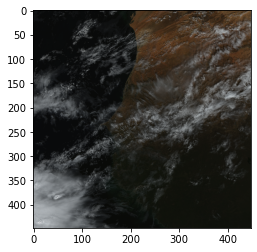

In [13]:
from tf_explain.callbacks.activations_visualization import ActivationsVisualizationCallback

image = np.expand_dims(X_test_reshaped[0],0)
# image = X_test_reshaped[0:10]
print(image.shape)
plt.figure(0)
plt.imshow(image[0])
plt.show()

# Define the Activation Visualization callback
# output_dir = './visualizations_modis'
output_dir = './modis_logs'
callbacks = [
    ActivationsVisualizationCallback(
        validation_data=(image,),
        layers_name=['conv2d_8'],
        output_dir=output_dir,
    ),
]

# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./tf_callback")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./modis_logs")

In [14]:
complete_model.fit(train_dataset,
                    epochs=5,
                    steps_per_epoch=len(X_train_reshaped)/batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(X_test_reshaped)/batch_size,
                    callbacks=[callbacks, tensorboard_callback],
                    use_multiprocessing=True
                  )


Epoch 1/5
10/9 [================================] - 18s 2s/step - loss: 0.0628 - val_loss: 0.2550
Epoch 2/5
10/9 [================================] - 15s 1s/step - loss: 0.0744 - val_loss: 0.0457
Epoch 3/5
10/9 [================================] - 15s 1s/step - loss: 0.0356 - val_loss: 0.0289
Epoch 4/5
10/9 [================================] - 15s 1s/step - loss: 0.0281 - val_loss: 0.0254
Epoch 5/5
10/9 [================================] - 15s 1s/step - loss: 0.0310 - val_loss: 0.0712


In [ ]:
# complete_model.save('../ssd/proxy_models/ae_epoch100_ucmerced')

## Model Testing

In [ ]:
from tf_explain.core.activations import ExtractActivations

# Define the Activation Visualization explainer
index = np.random.randint(0,len(X_test_reshaped))
# image = input_test[index].reshape((1, 32, 32, 3))
# image = np.expand_dims(X_test_reshaped[index],0)
image = X_test_reshaped[index:index+10]
label = image
print('val:', image.shape)

data = ([image])
explainer = ExtractActivations()

layers_of_interest = ['conv2d_1']
grid = explainer.explain(validation_data=data, model=complete_model, layers_name=['conv2d_1'])
print(grid.shape)
explainer.save(grid, '.', 'conv2d_1.png')

grid = explainer.explain(validation_data=data, model=complete_model, layers_name=['conv2d_2'])
print(grid.shape)
explainer.save(grid, '.', 'conv2d_2.png')

grid = explainer.explain(validation_data=data, model=complete_model, layers_name=['conv2d_3'])
print(grid.shape)
explainer.save(grid, '.', 'conv2d_3.png')

grid = explainer.explain(validation_data=data, model=complete_model, layers_name=['conv2d_8'])
print(grid.shape)
explainer.save(grid, '.', 'conv2d_8.png')

In [ ]:
for i in range(10):
    index=np.random.randint(0,len(X_test_reshaped))

    X_test_im=np.expand_dims(X_test_reshaped[index],0)
    out_image=np.squeeze(complete_model.predict(X_test_im))
    
    im_min=out_image.min(axis=(0, 1), keepdims=True)
    im_max=out_image.max(axis=(0, 1), keepdims=True)
    out_image=(out_image-im_min)/(im_max-im_min)
    
    
    print("Orig ",np.min(X_test_im),np.max(X_test_im))
    print("Gen ",np.min(out_image),np.max(out_image))
    fig=plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(X_test_reshaped[index])
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(X_test_im))
    plt.subplot(1,3,3)
    plt.imshow(out_image)
    plt.show()

## Modifying Loss Function

In [ ]:
model.save('/home/satyarth934/code/FDL_2020/proxy_tests/Models/model')